In [1]:
import time
from datetime import datetime
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from conv_sparse_model import ConvSparseLayer
from small_data_classifier import SmallDataClassifier

from load_data import load_covid_data
from train_conv3d_sparse_model import plot_filters
from train_conv3d_sparse_model import plot_video

from IPython.display import HTML

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*3
    # batch_size = 3

# train_loader = load_balls_data(batch_size)
train_loader, test_loader = load_covid_data(batch_size, clip_length_in_frames=20, frame_rate=20)

example_data = next(iter(train_loader))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 900/900 [06:31<00:00,  2.30it/s]


In [35]:
sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=8,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               shrink=0.15,
                               lam=0.15,
                               max_activation_iter=200,
                               activation_lr=1e-3)

#sparse_layer = torch.nn.Conv3d(in_channels=1,
#                                out_channels=16,
#                                kernel_size=10,
#                                stride=2,
#                                padding=0)

# inputs = torch.flatten(sparse_layer(example_data[1][0:1]), 1).shape[1]
# model = SmallDataClassifier(sparse_layer, inputs=inputs, outputs=3)
# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])

model = torch.nn.DataParallel(sparse_layer, device_ids=[0, 1, 2, 3])
model.to(device)

learning_rate = 3e-5
optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)
#optimizer = torch.optim.SGD(sparse_layer.parameters(),
#                            momentum=0.9,
#                            lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-14, max_lr=1e-5,step_size_up=20,mode="triangular2")

# criterion = torch.nn.CrossEntropyLoss()

In [36]:
model.train()
#for g in optimizer.param_groups:
#    g['lr'] = 5e-5

loss_log = []
best_so_far = float('inf')

for epoch in range(300):
    epoch_loss = 0
    epoch_start = time.perf_counter()
    error = None
    # for local_batch in train_loader:
    for labels, local_batch in train_loader:        
        local_batch = local_batch.to(device)
        
        torch_labels = torch.zeros(len(labels), dtype=torch.long)
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'covid']] = 1
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'pneumonia-bacterial']] = 2
        # torch_labels[[i for i in range(len(labels)) if labels[i] == 'pneumonia-viral']] = 3
        torch_labels = torch_labels.to(device)

        activations = model(local_batch)
        # pred, activations = model(local_batch)
        loss = sparse_layer.loss(local_batch, activations)
        # loss += criterion(pred, torch_labels)
        epoch_loss += loss.item() * local_batch.size(0)
        
        #pred = torch.softmax(pred, dim=1)
        #if error is None:
        #    error = (torch_labels != torch.argmax(pred, dim=1)).float()
        #else:
        #    error = torch.cat((error, (torch_labels != torch.argmax(pred, dim=1)).float()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sparse_layer.normalize_weights()
    
    epoch_end = time.perf_counter()    
    epoch_loss /= len(train_loader.sampler)
    
    if epoch_loss < best_so_far:
        print("found better model")
        # Save model parameters
        torch.save({
            'model_state_dict': model.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, datetime.now().strftime("saved_models/sparse_conv3d_model-best.pt"))
        best_so_far = epoch_loss
        
    loss_log.append(epoch_loss)
    print('epoch={}, epoch_loss={:.2f}, time={:.2f}'.format(epoch, epoch_loss, epoch_end - epoch_start))
    # print('epoch={}, epoch_loss={:.2f}, error={:.2f}, time={:.2f}'.format(epoch, epoch_loss, error.mean(), epoch_end - epoch_start))
    
    # scheduler.step(epoch_loss)
    # scheduler.step()

found better model
epoch=0, epoch_loss=8291.99, time=111.74
found better model
epoch=1, epoch_loss=5828.06, time=111.70
found better model
epoch=2, epoch_loss=4230.29, time=111.82
found better model
epoch=3, epoch_loss=3239.90, time=111.69
found better model
epoch=4, epoch_loss=2700.18, time=111.82
found better model
epoch=5, epoch_loss=2408.13, time=111.69
found better model
epoch=6, epoch_loss=2217.08, time=111.70
found better model
epoch=7, epoch_loss=2076.87, time=111.64
found better model
epoch=8, epoch_loss=1966.72, time=111.73
found better model
epoch=9, epoch_loss=1876.48, time=111.65
found better model
epoch=10, epoch_loss=1799.63, time=111.69
found better model
epoch=11, epoch_loss=1731.85, time=111.80
found better model
epoch=12, epoch_loss=1664.02, time=111.77
found better model
epoch=13, epoch_loss=1594.96, time=111.67
found better model
epoch=14, epoch_loss=1529.37, time=111.72
found better model
epoch=15, epoch_loss=1469.45, time=111.70
found better model
epoch=16, epoch

KeyboardInterrupt: 

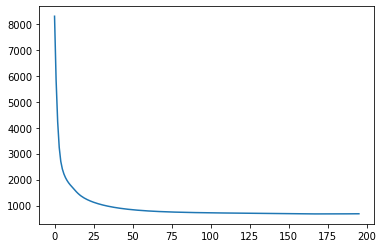

In [37]:
plt.plot(loss_log)

In [31]:
model.eval()
with torch.no_grad():
    epoch_loss = 0
    
    y_h = None
    y = None
    
    error = None
    
    t1 = time.perf_counter()
    # for local_batch in train_loader:
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)

        # print(labels)
        torch_labels = torch.zeros(len(labels), dtype=torch.long)
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'covid']] = 1
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'pneumonia-bacterial']] = 2
        # torch_labels[[i for i in range(len(labels)) if labels[i] == 'pneumonia-viral']] = 3
        torch_labels = torch_labels.to(device)
        
        pred, activations = model(local_batch)
        # loss = sparse_layer.loss(local_batch, activations)
        loss = criterion(pred, torch_labels)
        epoch_loss += loss.item() * local_batch.size(0)
        
        pred = torch.softmax(pred, dim=1)
        # print(pred)
        # print(torch_labels)

        if error is None:
            error = (torch_labels != torch.argmax(pred, dim=1)).float()
            y_h = torch.argmax(pred, dim=1)
            y = torch_labels
        else:
            error = torch.cat((error, (torch_labels != torch.argmax(pred, dim=1)).float()))
            y_h = torch.cat((y_h, torch.argmax(pred, dim=1)))
            y = torch.cat((y, torch_labels))
            
    t2 = time.perf_counter()
    
    print('loss={:.2f}, error={:.2f}, time={:.2f}'.format(loss, error.mean(), t2-t1))

loss=1.10, error=0.71, time=40.73


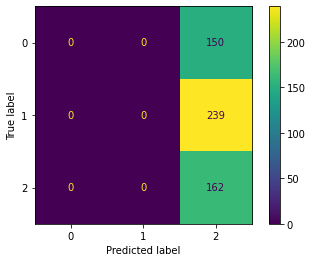

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y.cpu(), y_h.cpu())

cm_display = ConfusionMatrixDisplay(cm).plot()

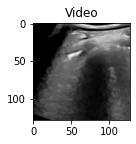

In [13]:
ani = plot_video(example_data[1][0])
HTML(ani.to_html5_video())

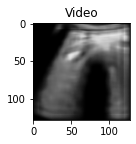

In [38]:
idx=0
activations = sparse_layer(example_data[1][idx:idx+1].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_video(reconstructions.squeeze(0))
# ani = plot_original_vs_recon(example_data[1][idx:idx+1], reconstructions, idx=0)
HTML(ani.to_html5_video())

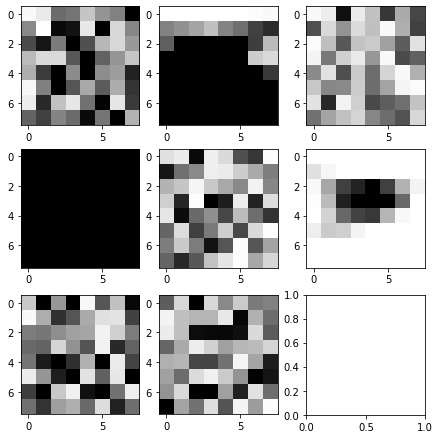

In [39]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())

In [ ]:
from torchvision.datasets.video_utils import VideoClips

In [ ]:
from os import listdir
from os.path import isfile, join, isdir, abspath
video_path = "/home/cm3786@drexel.edu/Projects/covid19_ultrasound/data/pocus_videos/convex"
labels = [name for name in listdir(video_path) if isdir(join(video_path, name))]
videos = []

for label in labels:
    videos.extend([(label, abspath(join(video_path, label, f))) for f in listdir(join(video_path, label)) if isfile(join(video_path, label, f))])

In [ ]:
vc = VideoClips([path for label, path in videos], clip_length_in_frames=16, frame_rate=20)

In [ ]:
example_data[1][0].shape

In [ ]:
ani = plot_video(vc.get_clip(2)[0].swapaxes(0, 1).swapaxes(0, 3).swapaxes(2, 3))
HTML(ani.to_html5_video())